In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


In [22]:
df=pd.read_csv("../data/master_table_cleaned.csv")

En esta etapa considero relevante separar el dataset por años, ya que realizar un split de entrenamiento de forma aleatoria podría provocar que el modelo acceda a información que en teoría debería predecir, como los datos de empresas del año 2024. En ese caso, el modelo no estaría aprendiendo patrones reales, sino simplemente memorizando la información futura, lo cual afectaría la validez y la capacidad de generalización del modelo.

In [23]:
target = 'GANANCIA (PÉRDIDA)_REAL'
cols_log_scale = ['TOTAL ACTIVOS_REAL'] # Magnitud (Billones)
cols_robust_only = [
    'Rotacion activos',        
    'Endeudamiento',  
    'PIB_Nacional',     
    'IPC_Anual',        
    'TRM_Promedio'      
]

cols_categorical = [
    'MACROSECTOR',
    'SUPERVISOR',
    'CIIU'     
]

features = cols_log_scale + cols_robust_only + cols_categorical

In [24]:
anio_corte_test = 2024

mask_train = df['Año de Corte'] < anio_corte_test
mask_test = df['Año de Corte'] == anio_corte_test

In [25]:
X_train = df.loc[mask_train, features]
y_train = df.loc[mask_train, target]

X_test = df.loc[mask_test, features]
y_test = df.loc[mask_test, target]

In [26]:
preprocessing = ColumnTransformer(
    transformers=[
        # 1. Activos: Logaritmo + RobustScaler
        ('log_robust', Pipeline([
            ('log', FunctionTransformer(np.log1p, validate=False)),
            ('scaler', RobustScaler())
        ]), cols_log_scale),

        # 2. Ratios y Macro: Solo RobustScaler
        ('robust', RobustScaler(), cols_robust_only),

        # 3. Categóricas: OneHotEncoder
        # handle_unknown='ignore' es vital para evitar errores si aparecen categorías nuevas
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cols_categorical)
    ],
    verbose_feature_names_out=False,
    remainder='drop' 
)

In [30]:
modelos = {
    "XGBoost Regressor": XGBRegressor(
        n_estimators=1000, 
        learning_rate=0.05, 
        max_depth=6, 
        n_jobs=-1, 
        random_state=42,
        objective='reg:absoluteerror' # Optimizar MAE directamente (ideal para outliers)
    ),
    
    "Random Forest": RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, # Limitamos profundidad para evitar overfitting
        n_jobs=-1, 
        random_state=42,
        criterion='squared_error' # Puede ser lento, si tarda mucho cambiar a 'squared_error'
    )
}

resultados = []    

In [31]:
for nombre, modelo in modelos.items():
    print(f"Entrenando {nombre}...")
    
    # Crear el Pipeline completo
    full_pipe = Pipeline([
        ('preprocessor', preprocessing),
        ('model', modelo)
    ])
    
    # A. ENTRENAR (FIT) con datos hasta 2023
    full_pipe.fit(X_train, y_train)
    
    # B. PREDECIR (PREDICT) datos de 2024
    y_pred = full_pipe.predict(X_test)
    
    # C. CALCULAR MÉTRICAS
    # MAE: En promedio, ¿cuánta plata me equivoco? (Robusta a outliers)
    mae = mean_absolute_error(y_test, y_pred)
    
    # MedAE: El error típico de la mayoría (ignora los casos extremos)
    med_ae = median_absolute_error(y_test, y_pred)
    
    # RMSE: Penaliza mucho los errores grandes
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # R2: Qué tanto varianza explicamos (Cuidado con outliers)
    r2 = r2_score(y_test, y_pred)
    
    # Guardar en la lista
    resultados.append({
        'Modelo': nombre,
        'MAE (Billones)': mae,
        'MedianAE (Billones)': med_ae,
        'RMSE': rmse,
        'R2 Score': r2
    })

Entrenando XGBoost Regressor...
Entrenando Random Forest...


,Modelo,MAE (Billones),MedianAE (Billones),RMSE,R2 Score
1,Random Forest,0.013556,0.001752,0.119335,0.627564
0,XGBoost Regressor,0.013684,0.000287,0.154764,0.373587


C:\Users\Juan Jose Cifuentes\AppData\Local\Temp\ipykernel_12840\1527320296.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados, x='Modelo', y='MAE (Billones)', palette='viridis')


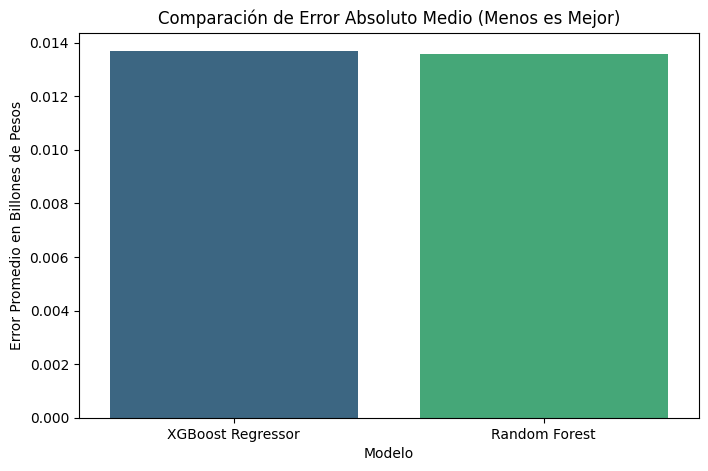

In [32]:

df_resultados = pd.DataFrame(resultados)

display(df_resultados.sort_values(by='MAE (Billones)'))

# Gráfica comparativa de MAE
plt.figure(figsize=(8, 5))
sns.barplot(data=df_resultados, x='Modelo', y='MAE (Billones)', palette='viridis')
plt.title('Comparación de Error Absoluto Medio (Menos es Mejor)')
plt.ylabel('Error Promedio en Billones de Pesos')
plt.show()

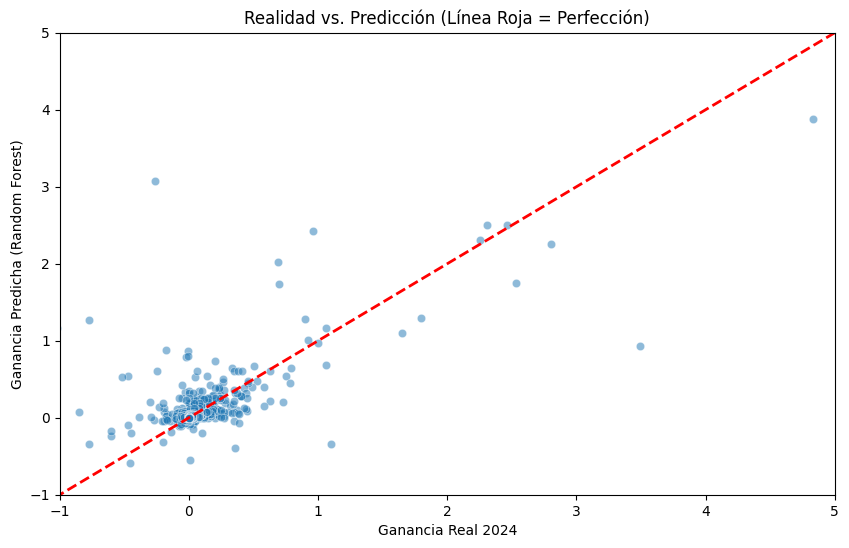

In [35]:
mejor_modelo_nombre = df_resultados.sort_values(by='MAE (Billones)').iloc[0]['Modelo']

modelo_ganador = modelos[mejor_modelo_nombre]
pipe_ganador = Pipeline([('preprocessor', preprocessing), ('model', modelo_ganador)])
pipe_ganador.fit(X_train, y_train)
y_pred_final = pipe_ganador.predict(X_test)

# A. Scatter Plot: Predicción vs Realidad
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Línea perfecta
plt.xlabel('Ganancia Real 2024')
plt.ylabel(f'Ganancia Predicha ({mejor_modelo_nombre})')
plt.title('Realidad vs. Predicción (Línea Roja = Perfección)')
# Hacemos zoom para ver la mayoría de empresas, ignorando outliers extremos en la gráfica
plt.xlim(-1, 5) 
plt.ylim(-1, 5)
plt.show()

In [ ]:
# B. Importancia de Variables (Solo para XGBoost o Random Forest)
if hasattr(modelo_ganador, 'feature_importances_'):
    # Extraer nombres de columnas del preprocesador
    nombres_cols = pipe_ganador.named_steps['preprocessor'].get_feature_names_out()
    importancias = modelo_ganador.feature_importances_
    
    df_imp = pd.DataFrame({'Variable': nombres_cols, 'Importancia': importancias})
    df_imp = df_imp.sort_values('Importancia', ascending=False).head(15) # Top 15
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=df_imp, x='Importancia', y='Variable', palette='magma')
    plt.title(f'Top 15 Variables más importantes para {mejor_modelo_nombre}')
    plt.show()